# HDA - Project 3
## TASK B1: Activity detection
This task consists of a binary classification, where a gesture denotes activity and thus the model detects wheter there is a gesture label or not (labeled in column 6).

This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: index of feature column to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
subject = 1
folder = "./data/full/"
label_col = 6     # 6 is default for task B1
window_size = 15
stride = 15
make_binary = True

In [2]:
import utils_old
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


Creation of training set and test set

In [3]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils_old.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)

# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# make the problem binary
if make_binary:
    Y_train[Y_train != 0] = 1
    Y_test[Y_test != 0] = 1

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])


Session shapes:
ADL1:   (45810, 110)
ADL2:   (28996, 110)
ADL3:   (30167, 110)
ADL4:   (30228, 110)
ADL5:   (27308, 110)
Drill:  (52152, 110)

Training samples:  157125 
Test samples:       57536 
Features:             110

Classes in training set:  2 
Classes in test set:      2


Preparation of data in a input-suitable form

In [4]:
print("Training set:")
X_train_s, Y_train_s = utils_old.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils_old.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)

Training set:
<class 'numpy.ndarray'> (10474, 15, 110) <class 'numpy.ndarray'> (10474, 2)

Features have shape:  (10474, 15, 110) 
Labels have shape:    (10474, 2) 
Fraction of labels:   [0.66612564 0.33387436]

Test set:
<class 'numpy.ndarray'> (3834, 15, 110) <class 'numpy.ndarray'> (3834, 2)

Features have shape:  (3834, 15, 110) 
Labels have shape:    (3834, 2) 
Fraction of labels:   [0.77464789 0.22535211]


<Figure size 2880x1440 with 0 Axes>

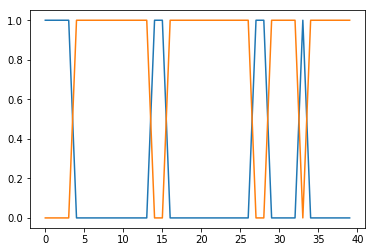

<Figure size 2880x1440 with 0 Axes>

In [5]:
plt.plot(Y_train_s[8950:8990, :])

plt.figure(figsize=(40,20))

In [6]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

In [ ]:
model_unidim = utils_old.Model1D((window_size, features), classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 18)            9918      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 18)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 36)             4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 36)             144       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 36)             0         
__________

In [ ]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 10474 samples, validate on 3834 samples
Epoch 1/10


In [ ]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [ ]:
# print results
#reverse the one-hot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils_old.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils_old.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils_old.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils_old.plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')

In [ ]:
plt.plot(Y_pred_hard)

In [ ]:
plt.plot(Y_test_hard)

In [ ]:
# revert one hot encoded windowed predicted labels to the unwindowed version
test_labels = utils_old.unwindowLabels(Y_test_s, window_size, stride)

## Task B2: gesture recognition
This task consists of a 17-class classification, where gestures are labeled in column 6.

To tune the following parameters, refer to the first cell of task B1:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: index of feature column to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

Here we just need to preserve the different labels, thus we set 'make_binary' to False. We have then 18 different labels, keeping into account the null class, with label 0.

In [ ]:
make_binary = False

In [ ]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils_old.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)

# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# make the problem binary
if make_binary:
    Y_train[Y_train != 0] = 1
    Y_test[Y_test != 0] = 1

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

In [ ]:
print("Training set:")
X_train_s, Y_train_s = utils_old.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False, null_class=False)
print("\nTest set:")
X_test_s, Y_test_s = utils_old.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False, null_class=False)
# add bars plot

In [ ]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

In [ ]:
model_unidim = utils_old.Model1D((window_size, features), classes)

In [ ]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

In [ ]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [ ]:
# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils_old.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils_old.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils_old.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils_old.plot_confusion_matrix(cnf_matrix, classes=[1,2],
                      title='Confusion matrix, without normalization')